In [4]:
import utils.Encryption as cen
import utils.CustomModel as cm
import utils.DataPipeline as dp
import tensorflow as tf
from PIL import Image
import json
import cv2 
import numpy as np
import matplotlib.pyplot as plt

d:\ProgramData\Anaconda3\envs\isic\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
root_dir = "F:\\pps_paper\\dataset"
train_dir = f"{root_dir}\\train"
test_dir = f"{root_dir}\\test"
validation_dir = f"{root_dir}\\validation"
# Change to E / P / PE / N
data_type = 'N'

train_images = f"{root_dir}\\train\\Data{data_type}"
train_masks = f"{root_dir}\\train\\GroundTruth_1{data_type}"
test_images = f"{root_dir}\\test\\Data{data_type}"
test_masks = f"{root_dir}\\test\\GroundTruth_1{data_type}"
validation_images = f"{root_dir}\\validation\\Data{data_type}"
validation_masks = f"{root_dir}\\validation\\GroundTruth_1{data_type}"



In [6]:
train = dp.CustomDataset(train_dir,input_dir=f'Data{data_type}', mask_dir=f'GroundTruth_1{data_type}').get_Dataset()
test = dp.CustomDataset(test_dir,input_dir=f'Data{data_type}', mask_dir=f'GroundTruth_1{data_type}').get_Dataset()
validation = dp.CustomDataset(validation_dir,input_dir=f'Data{data_type}', mask_dir=f'GroundTruth_1{data_type}').get_Dataset()

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
model = cm.CustomModel((256,256,3,))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
save_jc = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/',
    monitor='Specificity',
    save_weights_only = True
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer,
    metrics=
        [cm.DiceIndex(),
        cm.JaccardIndex(),
        cm.Sensitvity(),
        cm.Specificity(),
        cm.Accuracy(),],
    
    )

In [9]:
history = model.fit(train, validation_data=validation,batch_size=10,epochs=10,workers=2,validation_freq=2,callbacks=[save_jc],)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 0.1096 - Dice Index: 0.5298 - Jaccard Index: 0.4204 - Sensitivity: 0.5044 - Specificity: 0.9579 - Accuracy: 0.8641- ETA: 5s - loss: 0.1136 - Dice Index: 0.5214 - Ja - 80s 26ms/step - loss: 0.1096 - Dice Index: 0.5299 - Jaccard Index: 0.4205 - Sensitivity: 0.5045 - Specificity: 0.9579 - Accuracy: 0.8642
Epoch 2/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.0755 - Dice Index: 0.7106 - Jaccard Index: 0.6014 - Sensitivity: 0.7072 - Specificity: 0.9721 - Accuracy: 0.9042 - val_loss: 0.0915 - val_Dice Index: 0.6237 - val_Jaccard Index: 0.5147 - val_Sensitivity: 0.6357 - val_Specificity: 0.9739 - val_Accuracy: 0.8796
Epoch 3/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0673 - Dice Index: 0.7391 - Jaccard Index: 0.6323 - Sensitivity: 0.7634 - Specificity: 0.9736 - Accuracy: 0.9147
Epoch 4/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.0633 - Dice

In [10]:
history.model.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(10, 256, 256, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  608       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                 

<Figure size 432x288 with 0 Axes>

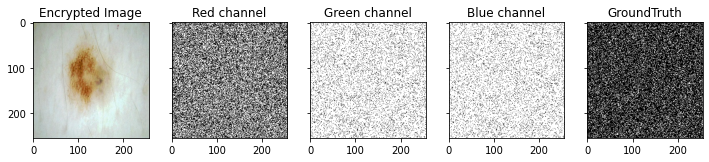

In [15]:
image_name = 'ISIC_0000376' 
img = cv2.imread(f'{train_images}\\{image_name}.jpg',1)
groundTruth = cv2.imread(f'{train_masks}\\{image_name}_segmentation.png',0)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv2.split(img)
Zb , Zg , Zr = Zb.flatten() , Zg.flatten() , Zr.flatten()  
# convert to np.float32
Zr = np.float32(Zr)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2

ret,label,center = cv2.kmeans(Zr,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
red = center[label.flatten()]
red = red.reshape((img.shape[0],img.shape[1]))

red = cen.unscramble(red,key)


# convert to np.float32
Zg = np.float32(Zg)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center = cv2.kmeans(Zg,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
green = center[label.flatten()]
green = green.reshape((img.shape[0],img.shape[1]))

green = cen.unscramble(green,key)


# convert to np.float32
Zb = np.float32(Zb)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center = cv2.kmeans(Zb,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
blue = center[label.flatten()]
blue = blue.reshape((img.shape[0],img.shape[1]))

blue = cen.unscramble(blue,key)


img = img[...,::-1]
groundTruth = cen.unscramble(groundTruth,key)



plt.figure()

fig , ax = plt.subplots(1,5,sharey=True,figsize = (12,3))
ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
ax[4].imshow(groundTruth,cmap='gray')
ax[4].set_title('GroundTruth')

plt.show()


Let's try plotting the predictions of our model

In [12]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

z = None
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    x = tf.keras.utils.array_to_img(display_list[i])
    x = np.array(x)
    # x = cen.unscramble(x,key)
    plt.imshow(x, cmap = None if i == 0 else 'gray')
    plt.axis('off')
  plt.show()

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      z = pred_mask
      display([image[0], mask[0], pred_mask[0]])

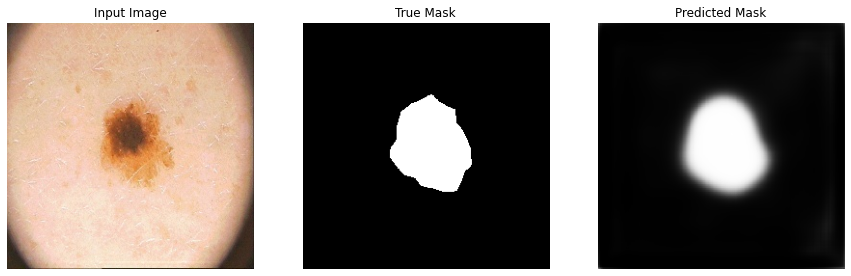

In [36]:
show_predictions(train)